<a href="https://colab.research.google.com/github/darthwaydr007/gan/blob/master/MNIST_Siamese_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd
import random
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")
    

There are 1 GPU available.
GPU: Tesla K80


In [ ]:
'''
BATCH_SIZE = 64
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

mnist_train = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=True, download=False, transform=transform)
mnist_test = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = BATCH_SIZE , shuffle = False , drop_last=True)
'''

"\nBATCH_SIZE = 64\n# MNIST Dataset\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean=(0.5), std=(0.5))])\n\nmnist_train = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=True, download=False, transform=transform)\nmnist_test = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=False, download=False, transform=transform)\n\ntrain_loader = torch.utils.data.DataLoader(mnist_train , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)\ntest_loader = torch.utils.data.DataLoader(mnist_test , batch_size = BATCH_SIZE , shuffle = False , drop_last=True)\n"

In [ ]:
mnist_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
train_labels = mnist_train.iloc[:,0]
mnist_train.drop(mnist_train.columns[0], axis=1, inplace=True)

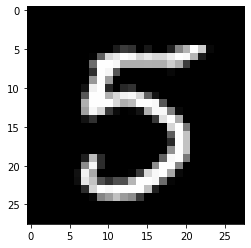

In [ ]:
image = mnist_train.iloc[0,:]
x= image.to_numpy()
plt.imshow(x.reshape(28, 28), cmap="gray")

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
def generate_dataset(mnist_train , train_labels, label_len):
  new_dataset1 = []
  new_dataset2 = []
  new_labels = []
  classes = train_labels.unique()
  for i in classes:
    #idx_list = [idx if i == x else -1 for idx, x in enumerate(train_labels)]
    idx_list = train_labels.index[train_labels.iloc[:] == i]
    not_idx_list = train_labels.index[train_labels.iloc[:] != i]
    for temp in range(0,label_len):
      #positive sample
      new_dataset1.append(torch.tensor(mnist_train.iloc[random.choice(idx_list)], dtype=torch.float , requires_grad=True))
      new_dataset2.append(torch.tensor(mnist_train.iloc[random.choice(idx_list)], dtype=torch.float , requires_grad=True))
      new_labels.append(torch.tensor(1., dtype=torch.float , requires_grad=True))
      #negative sample
      new_dataset1.append(torch.tensor(mnist_train.iloc[random.choice(idx_list)], dtype=torch.float , requires_grad=True))
      new_dataset2.append(torch.tensor(mnist_train.iloc[random.choice(not_idx_list)], dtype=torch.float , requires_grad=True))
      new_labels.append(torch.tensor(0., dtype=torch.float , requires_grad=True))
  return new_dataset1 , new_dataset2 , new_labels

In [ ]:
new_dataset1 , new_dataset2 , new_labels =generate_dataset(mnist_train , train_labels, 100)

In [ ]:
len(new_dataset2[0])

784

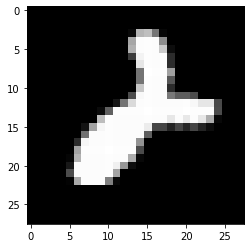

In [ ]:
x = new_dataset2[3]
x= x.detach().numpy()
plt.imshow(x.reshape(28, 28), cmap="gray")

In [ ]:
class SiameseDataset(Dataset):
  def __init__(self , train_dataset , labels, label_len ):
    self.train_dataset = train_dataset
    self.labels = labels
    self.label_len = label_len
    self.dataset1 , self.dataset2 , self.label = generate_dataset(self.train_dataset , self.labels , self.label_len)
    self.length = len(self.label)
  def __len__(self):
    return self.length

  def __getitem__(self , index):
    return {
        'img1' : self.dataset1[index] , 
        'img2' : self.dataset2[index] , 
        'label' :self.label[index]
    }


In [ ]:
mnist_training = SiameseDataset(mnist_train , train_labels, 1000 )
train_loader = torch.utils.data.DataLoader(mnist_training , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)

In [ ]:
class SiameseNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, 5)
        )
  
  def forward(self , image1 , image2):
    x1 = self.model(image1.view(image1.size(0),784))
    x2 = self.model(image2.view(image2.size(0),784))
    return x1.cuda(), x2.cuda()

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
siameseNet = SiameseNet().to(device)
criterion = ContrastiveLoss()
lr = 0.0002
optimizer = optim.Adam(siameseNet.parameters() , lr = lr)

In [ ]:
len(train_loader)

625

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

In [ ]:
def display_grid(images):
    grid_img = torchvision.utils.make_grid(images , nrow=1)
    npimgs = grid_img.cpu().detach().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='gray')
    plt.show()
#display_grid(images)

In [ ]:
for i in range(0,EPOCHS):
  siameseNet.train()
  total_loss = 0
  print('======== Epoch {:} / {:} ========'.format(i + 1, EPOCHS))
  for batch , (data) in enumerate(train_loader):
    
    img1 = data['img1']
    img1 = transform(img1.detach().numpy())
    img1 = img1.view(BATCH_SIZE,784).cuda()

    img2 = data['img2']
    img2 = transform(img2.detach().numpy())
    img2 = img2.view(BATCH_SIZE,784).cuda()


    label = data['label'].cuda()
    
    optimizer.zero_grad()
    x1 , x2 = siameseNet(img1 , img2)
    loss = criterion(x1 , x2 , label)
    loss.backward()
    optimizer.step()
    total_loss = total_loss + loss.mean().item()
    if batch % 100 == 0 and not batch == 0:
          #print(final_label)
          #img1 = img1[0].reshape(28, 28).cpu().detach()
          #img2 = img2[0].reshape(28, 28).cpu().detach()
          #print(label[0])
          #concatenated = torch.cat((img1, img2),0)
          #display_grid(concatenated)
          print('AvgLoss : {:} , Batch Loss : {:}'.format(total_loss/batch , loss.mean().item()))
          



======== Epoch 1 / 50 ========
AvgLoss : 2.889982805252075 , Loss : 1.0953013896942139
AvgLoss : 2.004250367283821 , Loss : 1.028244137763977
AvgLoss : 1.7085280881325404 , Loss : 1.2399752140045166
AvgLoss : 1.5540357099473476 , Loss : 0.951750636100769
AvgLoss : 1.4621913238763808 , Loss : 0.9679514169692993
AvgLoss : 1.4009782499074936 , Loss : 1.310915231704712
======== Epoch 2 / 50 ========
AvgLoss : 1.0927769553661346 , Loss : 1.0344451665878296
AvgLoss : 1.0874073857069015 , Loss : 1.0834368467330933
AvgLoss : 1.0848797070980072 , Loss : 0.8691000938415527
AvgLoss : 1.0830627673864364 , Loss : 1.0592280626296997
AvgLoss : 1.0845277520418166 , Loss : 1.076776385307312
AvgLoss : 1.0827523329854012 , Loss : 0.9136899709701538
======== Epoch 3 / 50 ========
AvgLoss : 1.0923879641294478 , Loss : 0.9793835878372192
AvgLoss : 1.076866545379162 , Loss : 1.1319777965545654
AvgLoss : 1.0816400810082754 , Loss : 1.0774611234664917
AvgLoss : 1.0751297976076604 , Loss : 1.1118276119232178
Av

In [ ]:
mnist_test = pd.read_csv('/content/sample_data/mnist_train_small.csv')
test_labels = mnist_test.iloc[:,0]
mnist_test.drop(mnist_test.columns[0], axis=1, inplace=True)

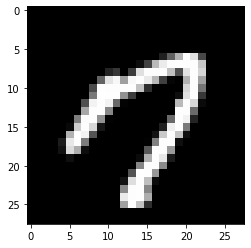

In [ ]:
image = mnist_test.iloc[1,:]
x= image.to_numpy()
plt.imshow(x.reshape(28, 28), cmap="gray")

In [ ]:
mnist_testing = SiameseDataset(mnist_test , test_labels , 5)
test_loader = torch.utils.data.DataLoader(mnist_testing , batch_size = 1, shuffle = False , drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.23646318912506104


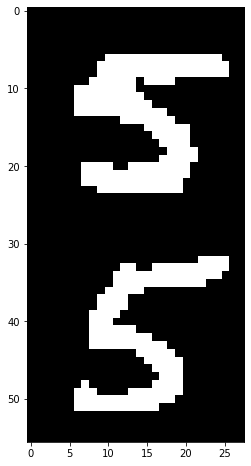

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.0998540073633194


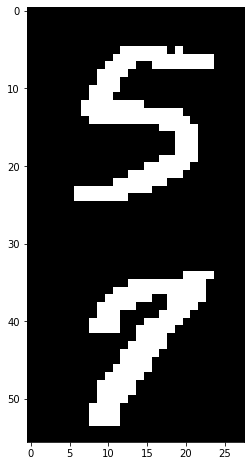

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.7301449775695801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


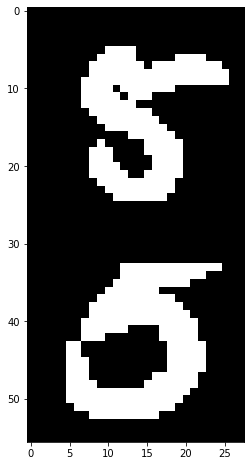

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.17285645008087158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


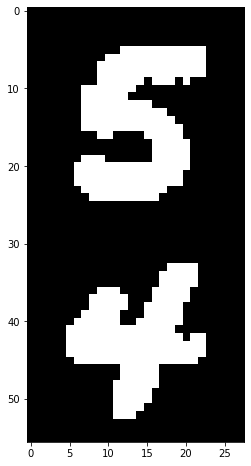

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4088493287563324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


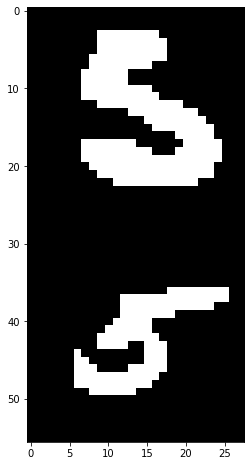

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
1.6688711643218994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


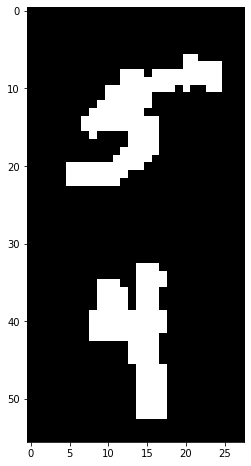

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.14254777133464813


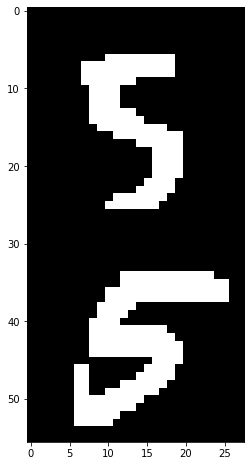

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.352026104927063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


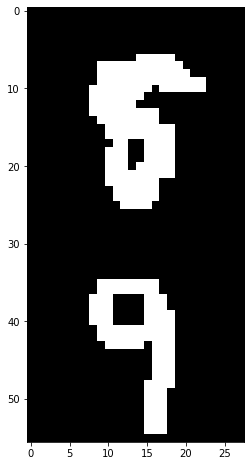

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
1.2144616842269897


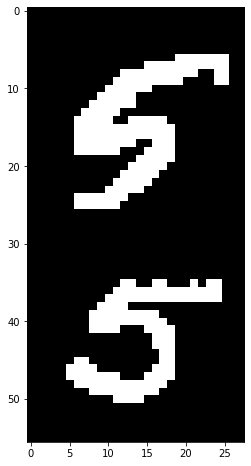

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.2752191126346588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


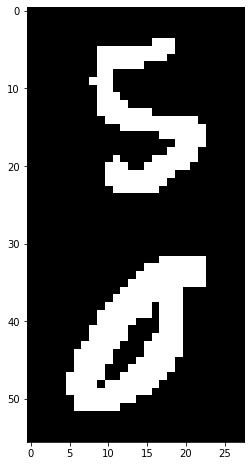

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.519764244556427


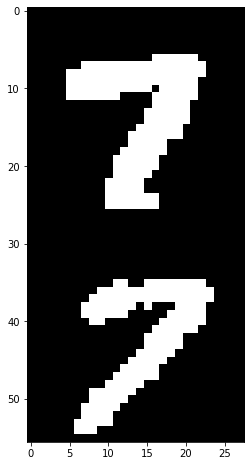

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3237738609313965


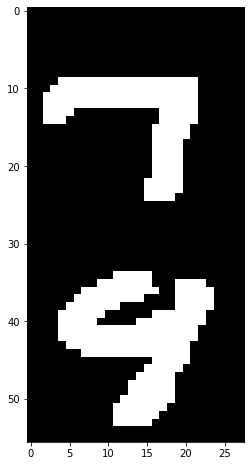

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3083439767360687


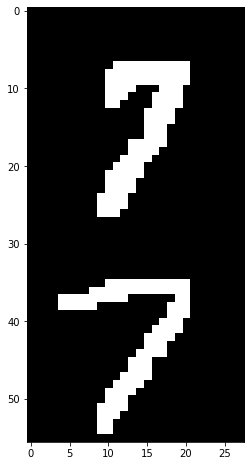

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.15314771234989166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


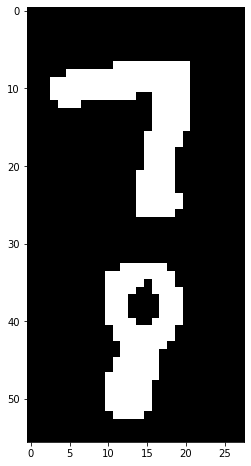

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.8122260570526123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


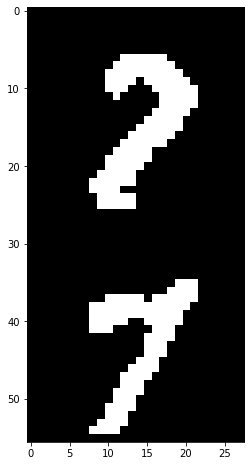

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.16032129526138306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


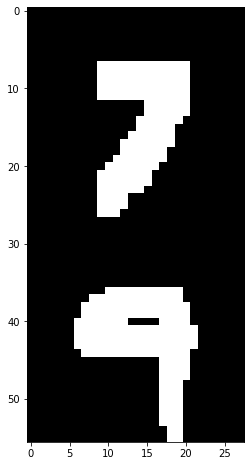

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.18085160851478577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


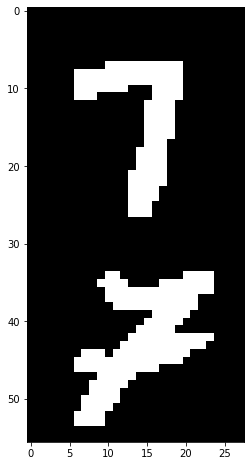

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3570430874824524


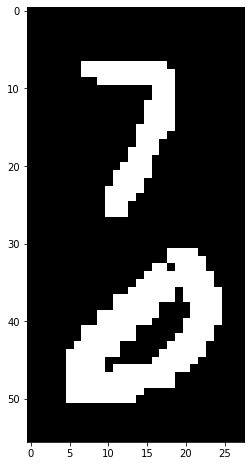

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.39235007762908936


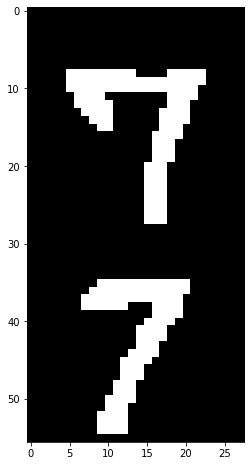

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4304858446121216


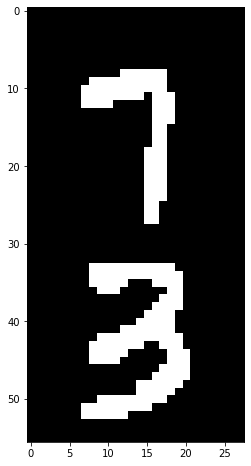

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.49672314524650574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


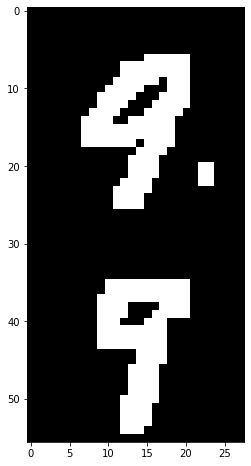

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.5397748351097107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


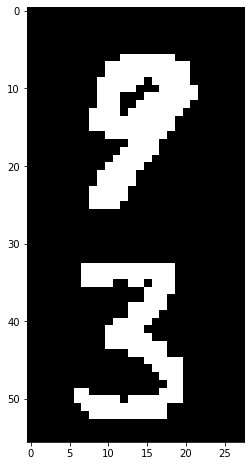

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3871699571609497


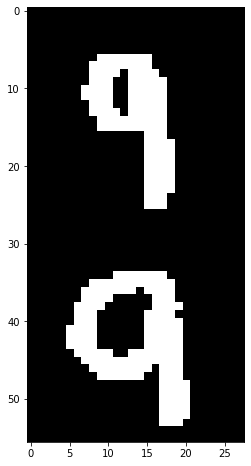

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.6610285043716431


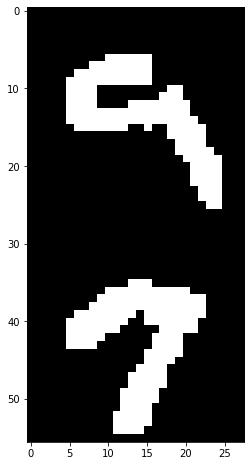

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.8089872598648071


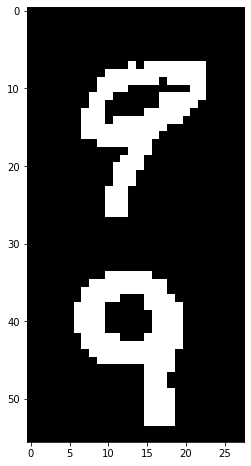

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.8419790863990784


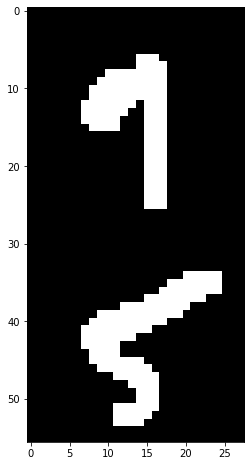

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.7860424518585205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


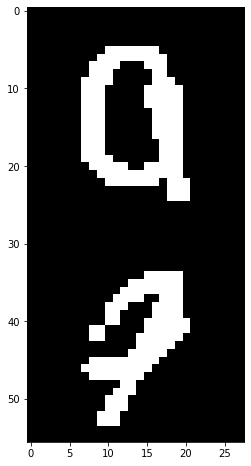

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4079109728336334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


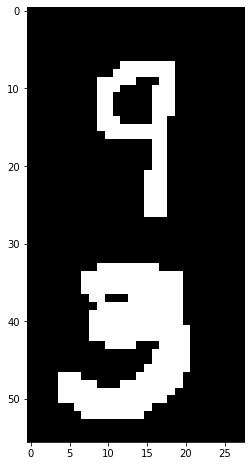

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.27223682403564453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


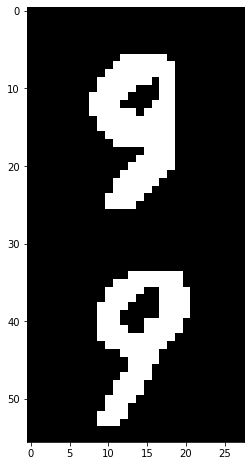

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.715343713760376


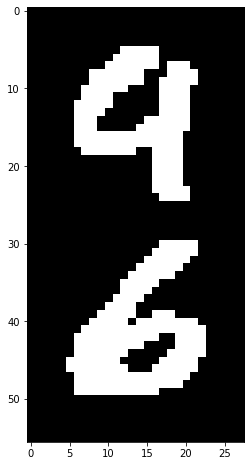

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.412849098443985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


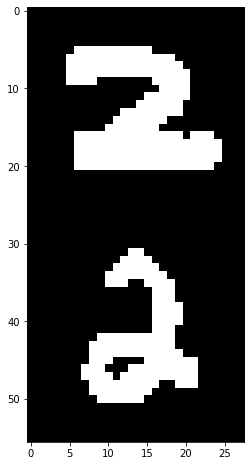

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.8146734833717346


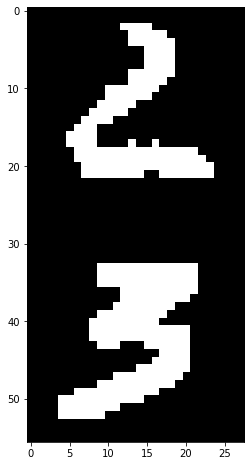

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.43387266993522644


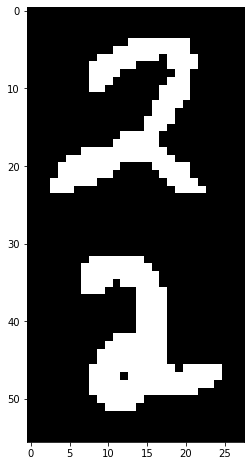

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.10937416553497314


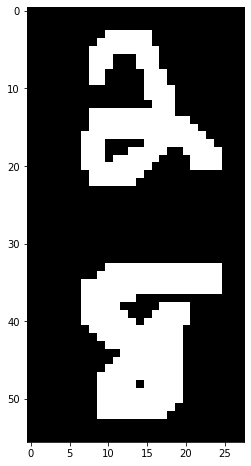

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.36785009503364563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


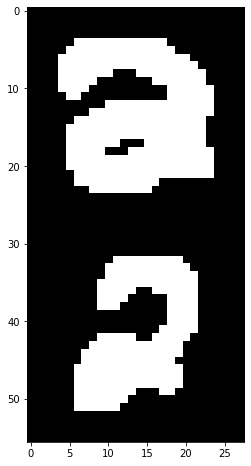

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.32478857040405273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


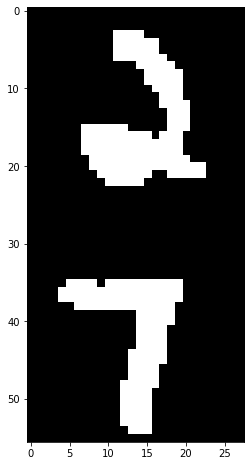

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.24246905744075775


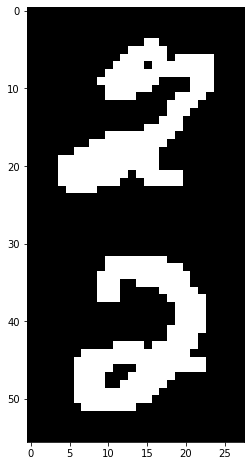

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.39763104915618896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


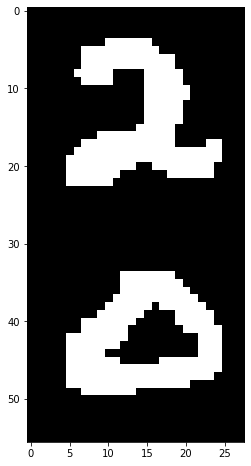

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.30218052864074707


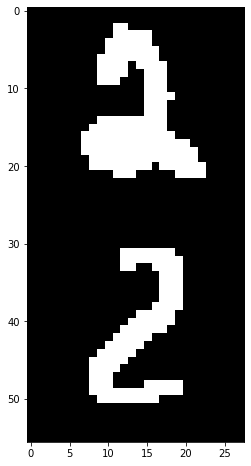

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.16105860471725464


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


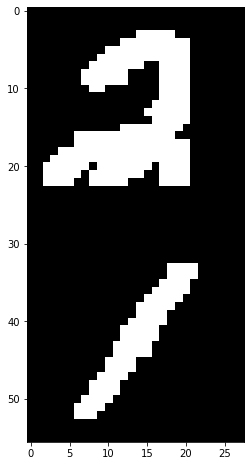

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.21625590324401855


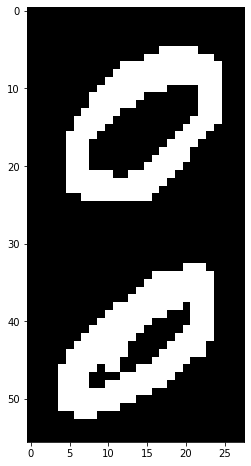

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3015967607498169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


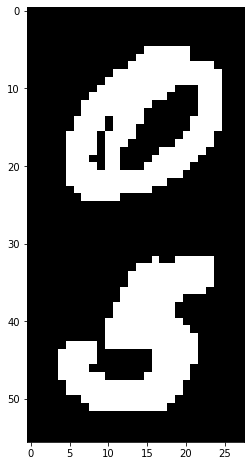

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4114440381526947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


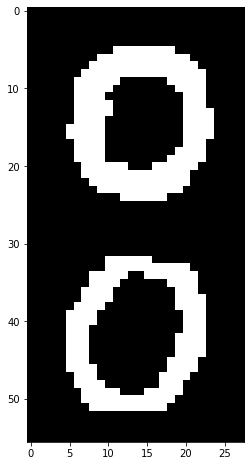

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3671271502971649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


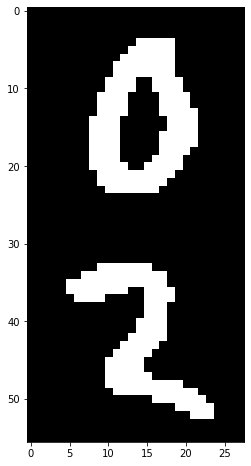

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.7314351201057434


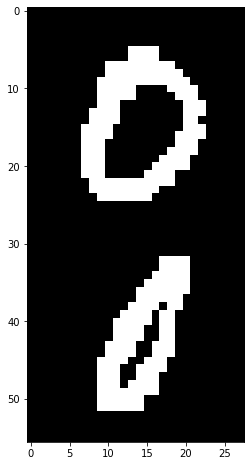

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.21349403262138367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


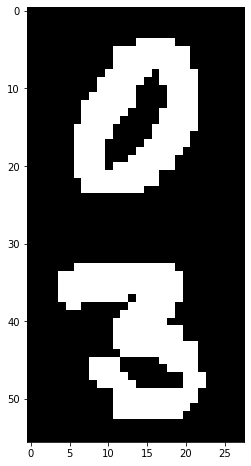

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.2521706521511078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


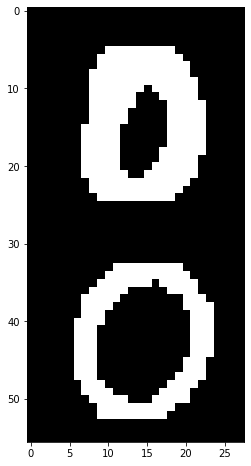

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.19490927457809448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


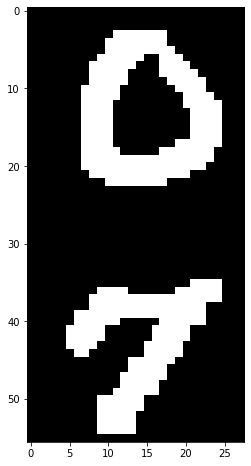

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.29947519302368164


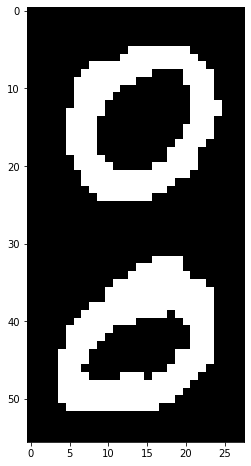

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.6202192306518555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


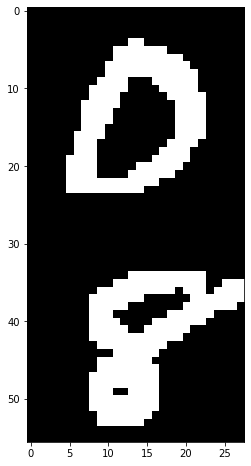

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.34052759408950806


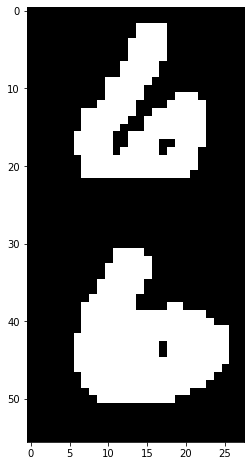

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.49641773104667664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


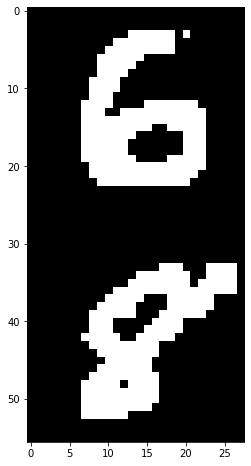

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.39096885919570923


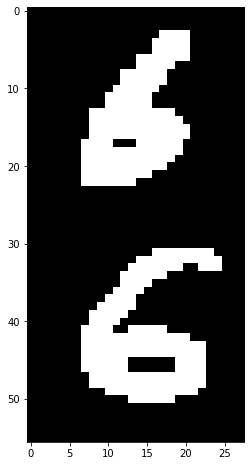

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.1709694266319275


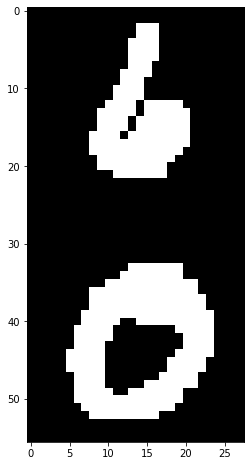

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.45946505665779114


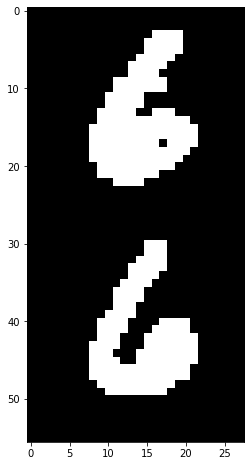

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4104618430137634


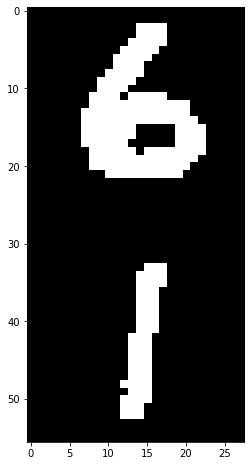

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.7150676846504211


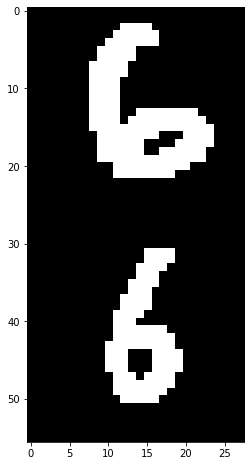

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.16787441074848175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


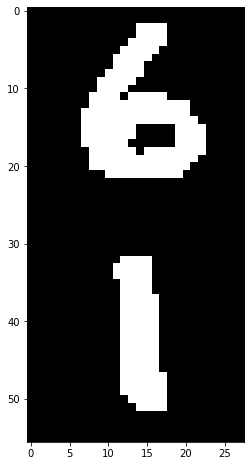

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
1.7584154605865479


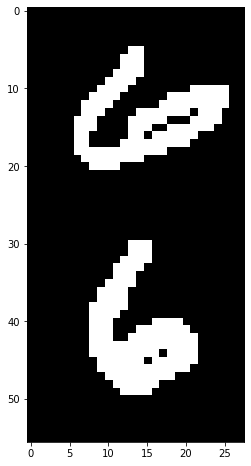

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.8436579704284668


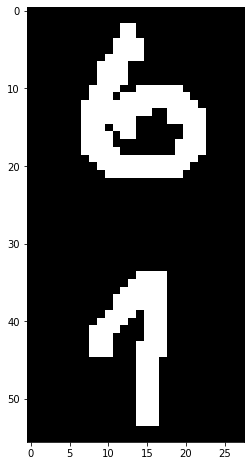

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
1.2575427293777466


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


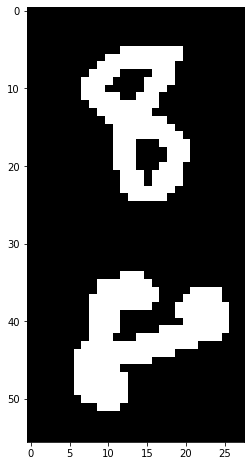

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.32542261481285095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


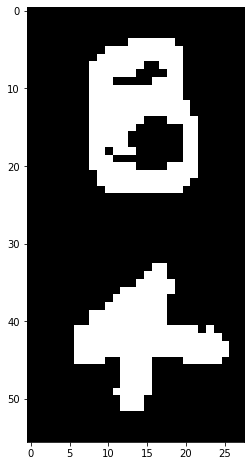

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.20401857793331146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


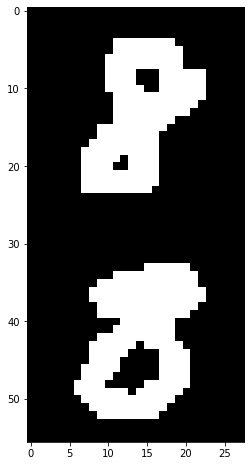

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.19809980690479279


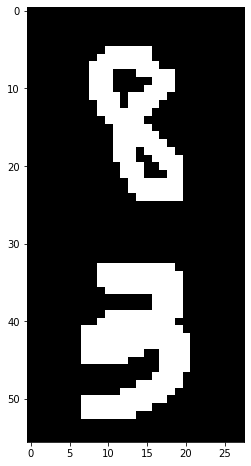

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.6170476675033569


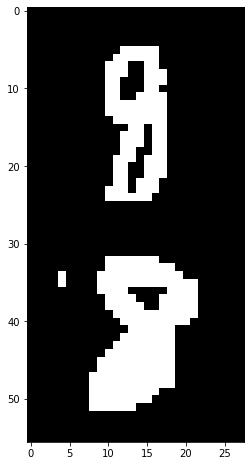

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
1.1731568574905396


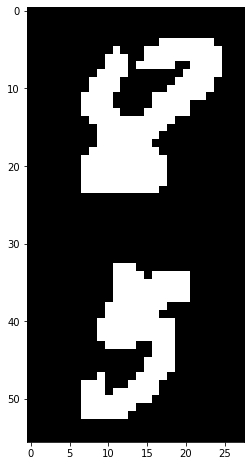

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.5277333855628967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


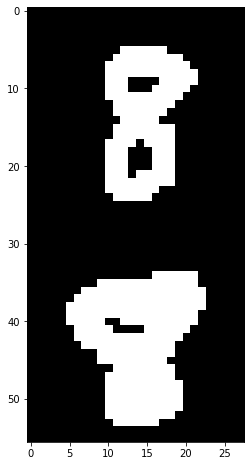

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4881057143211365


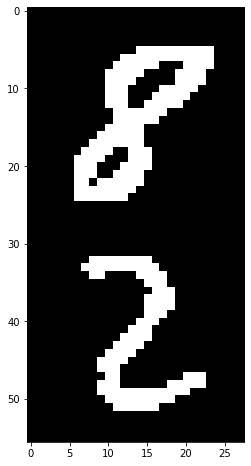

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.44797566533088684


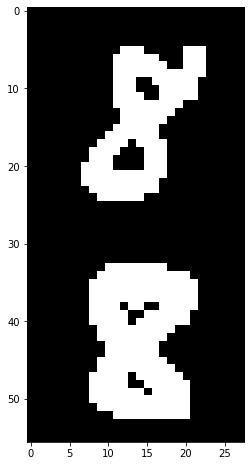

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.17435885965824127


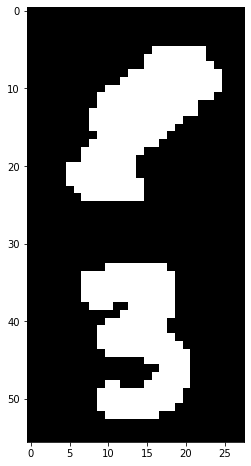

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.17859791219234467


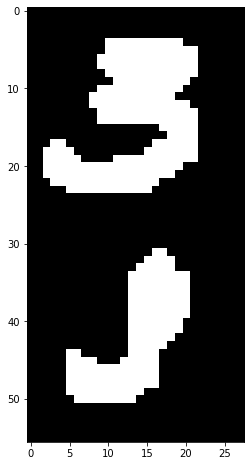

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.11100534349679947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


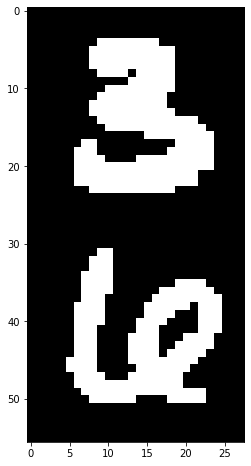

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4123050272464752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


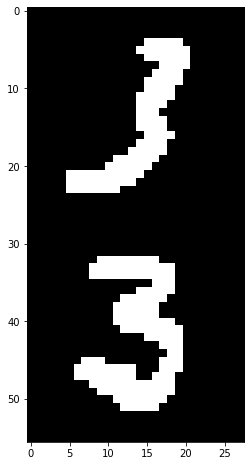

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
3.121037721633911


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


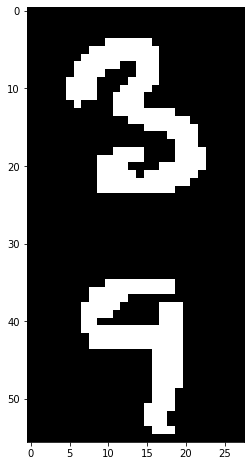

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.2223035842180252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


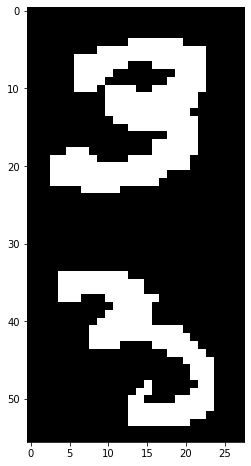

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.35232338309288025


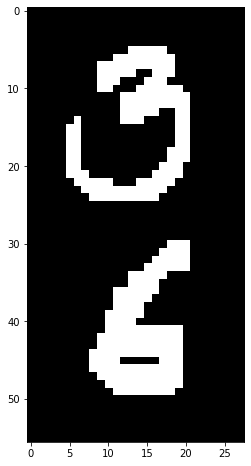

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.16269896924495697


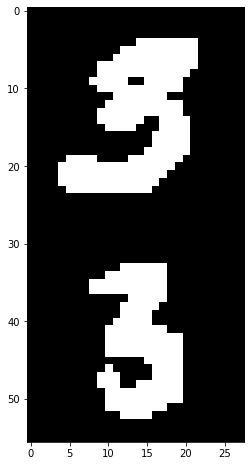

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.19361568987369537


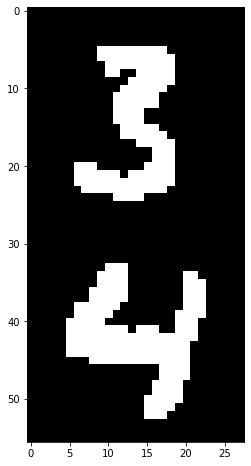

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.22204206883907318


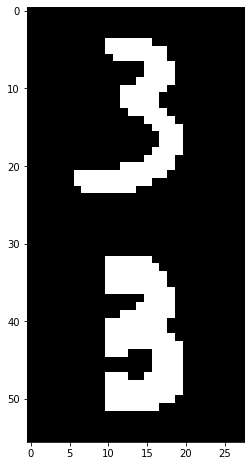

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.24021746218204498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


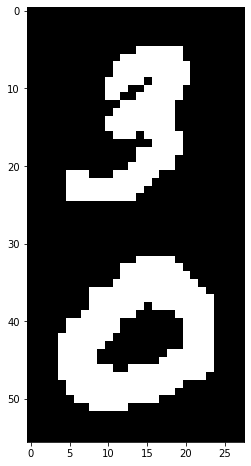

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.6555781960487366


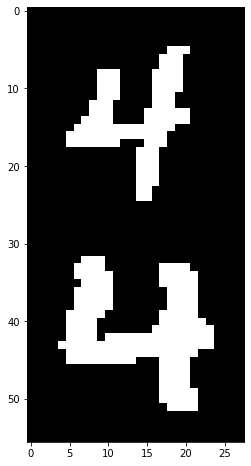

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.2612718641757965


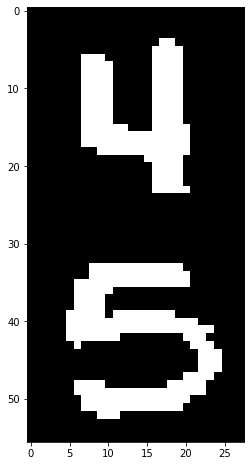

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.48714184761047363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


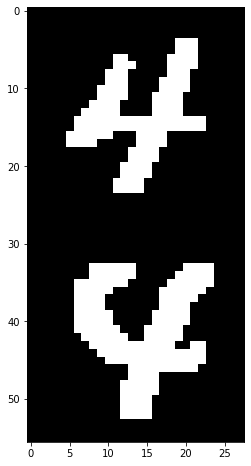

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.2151324599981308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


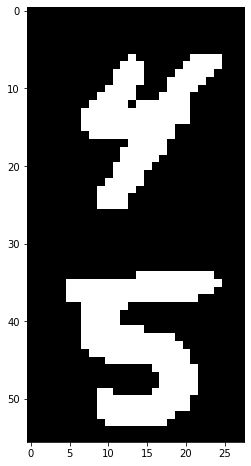

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.29747939109802246


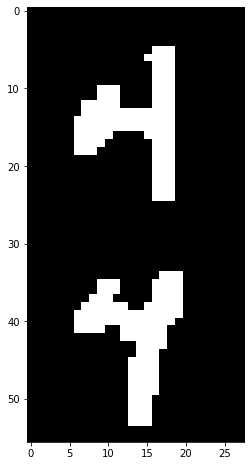

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.7512289881706238


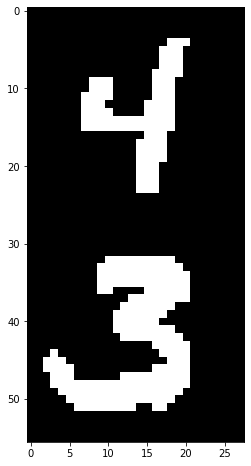

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4027443826198578


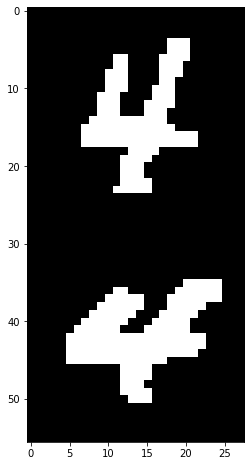

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
1.189945936203003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


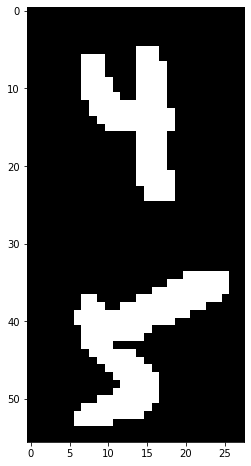

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.30256474018096924


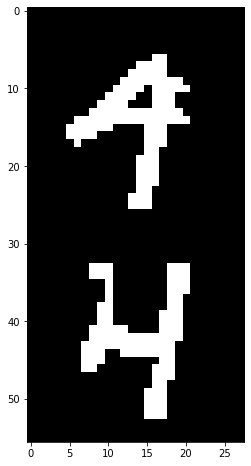

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4119301438331604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


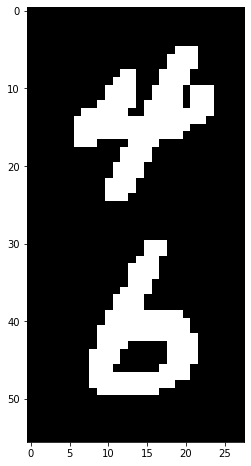

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.3353075385093689


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


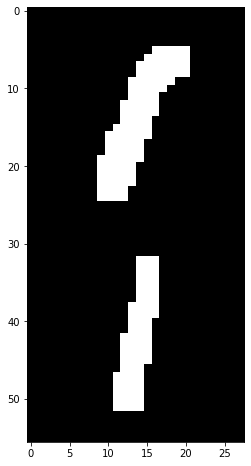

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4322427809238434


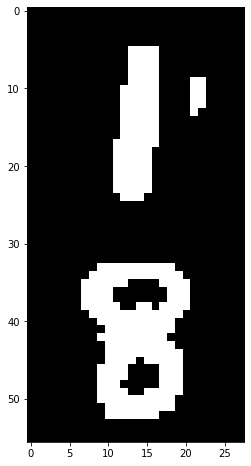

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
1.2891604900360107


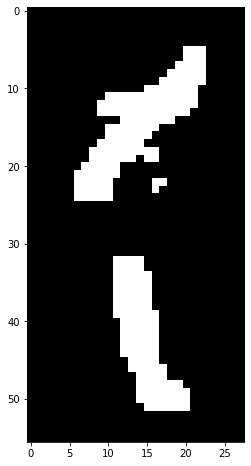

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.6074843406677246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


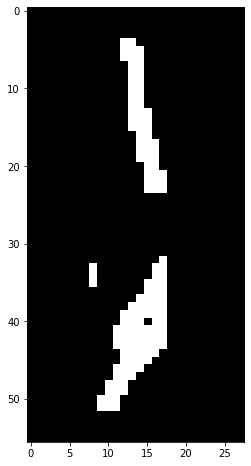

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.2173546999692917


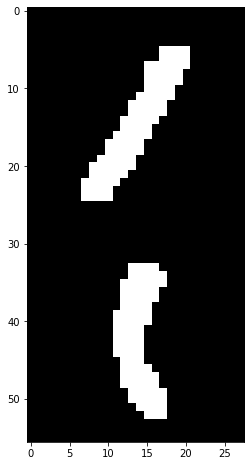

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.25715380907058716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


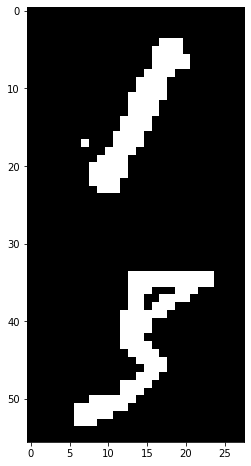

tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.07876184582710266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


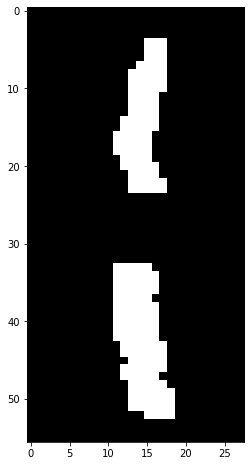

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.4277524948120117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


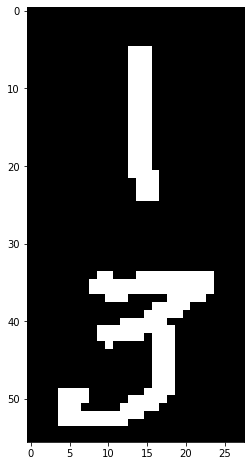

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>)
0.8073017001152039


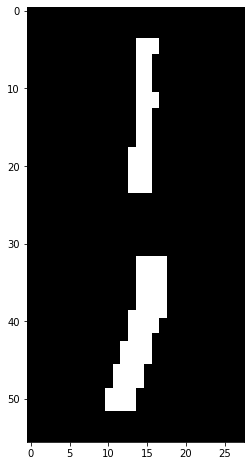

tensor([0.], device='cuda:0', grad_fn=<CopyBackwards>)
0.13373617827892303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


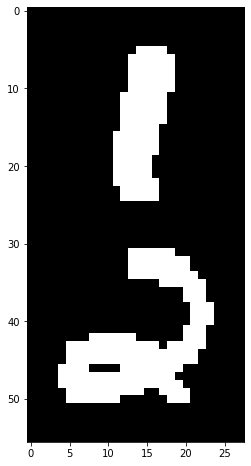

In [ ]:
total = 0
correct = 0
siameseNet.eval()
for batch , (data) in enumerate(test_loader):
  
  img1 = data['img1']
  
  img1 = transform(img1.detach().numpy())
  img1 = img1.view(1,784).cuda()

  img2 = data['img2']
  img2 = transform(img2.detach().numpy())
  img2 = img2.view(1,784).cuda()


  label = data['label'].cuda()
  
  x1 , x2 = siameseNet(img1 , img2)
  dissimilarity = F.pairwise_distance(x1, x2)
  #loss = criterion(img1 , img2 , label)
  #total_loss = total_loss + loss.mean().item()
  #concatenated = torch.cat((img1.cpu().detach(),img2.cpu().detach()),0)
  #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(dissimilarity.item()))
  img1 = img1.reshape(28, 28).cpu().detach()
  img2 = img2.reshape(28, 28).cpu().detach()
  print(label)
  print(dissimilarity.item())
  concatenated = torch.cat((img1, img2),0)
  display_grid(concatenated)